In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
import pickle
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load the dataset

file_path = "E:\NSU Semester\10th Semester\CSE445\ITN\Assignment\Project\Web_app\Merged_dataset_final.csv"
df = pd.read_csv(file_path)

In [99]:
# Display the first few rows

print("Dataset Overview:")
print(df.head())

Dataset Overview:
   Year      Region  Rice Type  Area (Hectare)  Yield (Metric tons)  \
0  2016    Barishal  Aus Local           14731              16632.0   
1  2016       Bhola  Aus Local           48386              63376.0   
2  2016  Patuakhali  Aus Local           16678              21538.0   
3  2016    Chandpur  Aus Local             613                834.0   
4  2016  Chattogram  Aus Local            6663              10695.0   

   Temperature (°C)  Rainfall (mm)  Humidity (Percent)  
0             28.60         314.33               81.33  
1             28.33         300.67               82.83  
2             28.77         347.33               84.67  
3             28.50         316.00               78.50  
4             28.22         269.33               78.83  


In [100]:
# Check for missing values

print("\nMissing values in each column:")
print(df.isnull().sum())

# Fill missing values
# For numerical columns: use median
numerical_cols = ['Area (Hectare)', 'Temperature (°C)', 'Rainfall (mm)', 'Humidity (Percent)']
for col in numerical_cols:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].median())


Missing values in each column:
Year                    0
Region                  0
Rice Type               0
Area (Hectare)          0
Yield (Metric tons)     1
Temperature (°C)        0
Rainfall (mm)          30
Humidity (Percent)     31
dtype: int64


In [101]:

# For categorical columns: use mode

categorical_cols = ['Region', 'Rice Type']
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].mode()[0])

In [102]:
# Check for any remaining missing values
print("\nMissing values after imputation:")
print(df.isnull().sum())


Missing values after imputation:
Year                   0
Region                 0
Rice Type              0
Area (Hectare)         0
Yield (Metric tons)    1
Temperature (°C)       0
Rainfall (mm)          0
Humidity (Percent)     0
dtype: int64


In [103]:
# Convert data types if needed
# Ensure all numeric columns are properly converted
for col in numerical_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [104]:
# Fill any newly created NaN values from the conversion
for col in numerical_cols:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].median())

In [105]:
# Make sure Year is an integer
df['Year'] = pd.to_numeric(df['Year'], errors='coerce').fillna(df['Year'].median()).astype(int)

In [106]:
# Make sure Yield column is numeric and has no NaN values
df['Yield (Metric tons)'] = pd.to_numeric(df['Yield (Metric tons)'], errors='coerce')
if df['Yield (Metric tons)'].isnull().sum() > 0:
    print(f"Warning: Found {df['Yield (Metric tons)'].isnull().sum()} missing values in target column.")
    # For demonstration, fill with median - in practice, you might want to drop these rows
    df['Yield (Metric tons)'] = df['Yield (Metric tons)'].fillna(df['Yield (Metric tons)'].median())

In [107]:
# Check data types and statistics
print("\nData Types after conversion:")
print(df.dtypes)

print("\nData Statistics:")
print(df.describe())


Data Types after conversion:
Year                     int32
Region                  object
Rice Type               object
Area (Hectare)           int64
Yield (Metric tons)    float64
Temperature (°C)       float64
Rainfall (mm)          float64
Humidity (Percent)     float64
dtype: object

Data Statistics:
              Year  Area (Hectare)  Yield (Metric tons)  Temperature (°C)  \
count  1792.000000     1792.000000          1792.000000       1792.000000   
mean   2019.500000    27259.698661         84375.972098         27.325977   
std       2.291927    43971.270268        145828.636404          1.981199   
min    2016.000000        0.000000             0.000000          0.000000   
25%    2017.750000      448.500000           800.250000         26.417500   
50%    2019.500000     6607.500000         13404.000000         27.670000   
75%    2021.250000    36579.250000        111779.500000         28.590000   
max    2023.000000   274604.000000        962273.000000         31.120000 

In [109]:
# Function to remove outliers using IQR method
def remove_outliers(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

In [110]:
# Remove outliers
df_clean = remove_outliers(df, numerical_cols)
print(f"\nRows before outlier removal: {len(df)}")
print(f"Rows after outlier removal: {len(df_clean)}")


Rows before outlier removal: 1792
Rows after outlier removal: 1532


In [112]:
# Prepare data for modeling
X = df_clean.drop('Yield (Metric tons)', axis=1)
y = df_clean['Yield (Metric tons)']

In [113]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [114]:
# Define preprocessing pipeline with imputers to handle any remaining NaNs
numeric_features = ['Area (Hectare)', 'Temperature (°C)', 'Rainfall (mm)', 'Humidity (Percent)', 'Year']
categorical_features = ['Region', 'Rice Type']

In [115]:
# Preprocessing for numerical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Add imputer
    ('scaler', StandardScaler())
])

In [116]:
# Preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Add imputer
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [117]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [118]:
# Create the modeling pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42, missing=np.nan))  # Set missing parameter
])

In [119]:
# Train the model
print("\nTraining model...")
model_pipeline.fit(X_train, y_train)


Training model...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Area (Hectare)',
                                                   'Temperature (°C)',
                                                   'Rainfall (mm)',
                                                   'Humidity (Percent)',
                                                   'Year']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unk...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [120]:
# Make predictions
try:
    print("Making predictions on training set...")
    y_train_pred = model_pipeline.predict(X_train)
    
    print("Making predictions on test set...")
    y_test_pred = model_pipeline.predict(X_test)
finally:
    print()

Making predictions on training set...
Making predictions on test set...



In [121]:
# Check for NaN values in predictions
print(f"NaN values in training predictions: {np.isnan(y_train_pred).sum()}")
print(f"NaN values in test predictions: {np.isnan(y_test_pred).sum()}")

NaN values in training predictions: 0
NaN values in test predictions: 0


In [122]:
# Replace any NaN values in predictions with mean prediction value
if np.isnan(y_train_pred).any():
        train_mean = np.nanmean(y_train_pred)
        y_train_pred = np.nan_to_num(y_train_pred, nan=train_mean)
        
if np.isnan(y_test_pred).any():
        test_mean = np.nanmean(y_test_pred)
        y_test_pred = np.nan_to_num(y_test_pred, nan=test_mean)

In [ ]:
 # Evaluate the model
try:    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    print("\nModel Evaluation:")
    print(f"Training RMSE: {train_rmse:.2f}")
    print(f"Testing RMSE: {test_rmse:.2f}")
    print(f"Training R²: {train_r2:.2f}")
    print(f"Testing R²: {test_r2:.2f}")
except Exception as e:
    print(f"Error during evaluation: {e}")
    print("Let's diagnose the issue:")


Model Evaluation:
Training RMSE: 404.94
Testing RMSE: 9779.58
Training R²: 1.00
Testing R²: 0.98


In [124]:
# Debug information
print("\nDebugging info:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


Debugging info:
X_train shape: (1225, 7)
X_test shape: (307, 7)
y_train shape: (1225,)
y_test shape: (307,)


In [125]:
 # Check if XGBoost params need adjusting
print("\nRetrying with adjusted XGBoost parameters...")


Retrying with adjusted XGBoost parameters...


In [126]:
# Create a simpler model with more robust handling of missing values
model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(
            random_state=42,
            missing=np.nan,
            n_estimators=100,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8
        ))
    ])

In [127]:
# Retrain
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Area (Hectare)',
                                                   'Temperature (°C)',
                                                   'Rainfall (mm)',
                                                   'Humidity (Percent)',
                                                   'Year']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unk...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [128]:
# Predict again
y_train_pred = model_pipeline.predict(X_train)
y_test_pred = model_pipeline.predict(X_test)

In [129]:
 # Fill any NaN values in predictions
y_train_pred = np.nan_to_num(y_train_pred, nan=y_train.mean())
y_test_pred = np.nan_to_num(y_test_pred, nan=y_test.mean())

In [130]:
# Evaluate the model
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
    
print("\nModel Evaluation after adjustment:")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")
print(f"Training R²: {train_r2:.2f}")
print(f"Testing R²: {test_r2:.2f}")


Model Evaluation after adjustment:
Training RMSE: 1888.70
Testing RMSE: 9825.61
Training R²: 1.00
Testing R²: 0.98


In [131]:
# Check for overfitting
print("\nOverfitting Check:")
if train_rmse < test_rmse * 0.7:
    print("Model might be overfitting. Consider regularization or simpler model.")


Overfitting Check:
Model might be overfitting. Consider regularization or simpler model.


In [132]:
# Hyperparameter tuning to address overfitting - with simpler grid
param_grid = {
        'regressor__n_estimators': [50, 100],
        'regressor__max_depth': [3, 5],
        'regressor__learning_rate': [0.01, 0.1],
        'regressor__reg_alpha': [0.1, 1.0],
        'regressor__reg_lambda': [0.1, 1.0]
    }
    
try:
        grid_search = GridSearchCV(model_pipeline, param_grid, cv=3, 
                                 scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        
        print(f"Best parameters: {grid_search.best_params_}")
finally:
        print()

Best parameters: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__n_estimators': 100, 'regressor__reg_alpha': 0.1, 'regressor__reg_lambda': 0.1}



In [133]:
 # Update model with best parameters
model_pipeline = grid_search.best_estimator_

In [134]:
 # Re-evaluate
y_train_pred = model_pipeline.predict(X_train)
y_test_pred = model_pipeline.predict(X_test)

In [139]:
 # Fill any NaN values
try:
    y_train_pred = np.nan_to_num(y_train_pred, nan=y_train.mean())
    y_test_pred = np.nan_to_num(y_test_pred, nan=y_test.mean())
        
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
        
    print("\nModel Evaluation After Tuning:")
    print(f"Training RMSE: {train_rmse:.2f}")
    print(f"Testing RMSE: {test_rmse:.2f}")
    print(f"Training R²: {train_r2:.2f}")
    print(f"Testing R²: {test_r2:.2f}")
except Exception as e:
    print(f"Error during hyperparameter tuning: {e}")
    print("Skipping hyperparameter tuning...")
else:
   print("Model does not show signs of significant overfitting.")


Model Evaluation After Tuning:
Training RMSE: 2481.36
Testing RMSE: 9230.26
Training R²: 1.00
Testing R²: 0.98
Model does not show signs of significant overfitting.


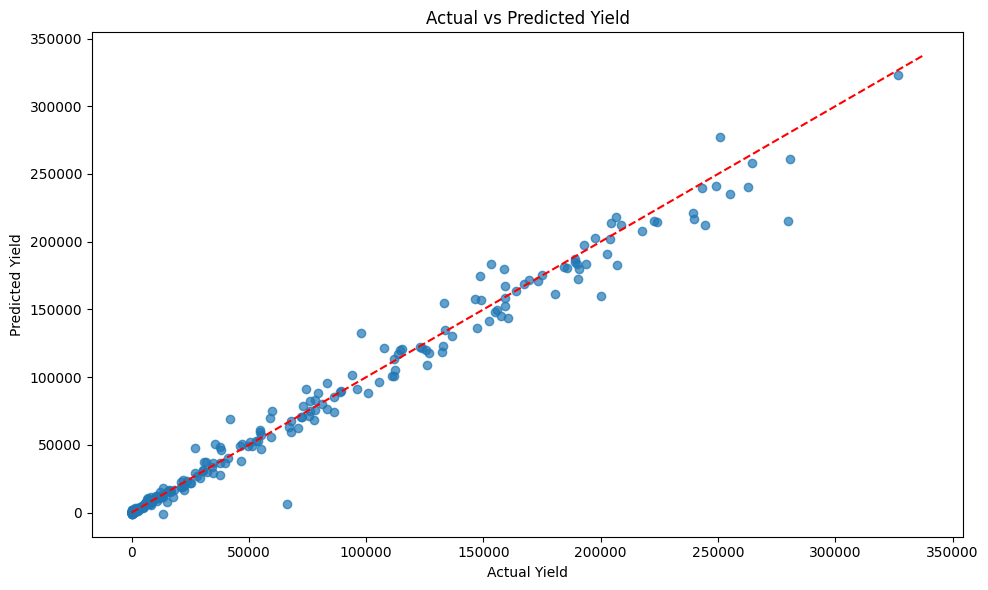

In [140]:
# Visualize actual vs predicted values
try:
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_test_pred, alpha=0.7)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
    plt.xlabel('Actual Yield')
    plt.ylabel('Predicted Yield')
    plt.title('Actual vs Predicted Yield')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error during visualization: {e}")

In [141]:
# Create a lightweight version of the model for prediction
# First, create a label encoder for the Region column
le_region = LabelEncoder()
le_region.fit(df['Region'].unique())

LabelEncoder()

In [142]:
# Save the model and preprocessor
with open('rice_yield_model.pkl', 'wb') as f:
    pickle.dump(model_pipeline, f)

In [143]:
# Save the region encoder
with open('region_encoder.pkl', 'wb') as f:
    pickle.dump(le_region, f)

In [144]:
# Save the unique rice types for reference
rice_types = df['Rice Type'].unique().tolist()
with open('rice_types.pkl', 'wb') as f:
    pickle.dump(rice_types, f)

print("\nModel and necessary components saved for prediction.")
print("Use 'rice_yield_model.pkl', 'region_encoder.pkl' and 'rice_types.pkl' for predictions.")


Model and necessary components saved for prediction.
Use 'rice_yield_model.pkl', 'region_encoder.pkl' and 'rice_types.pkl' for predictions.
